## Import libraries

In [ ]:
### scientific libraries
import numpy as np
import umap
from sklearn.neighbors import KDTree

### visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

### image manipulation libraries
from PIL import Image

### path manipulation libraries
from pathlib import Path
from typing import Tuple, List, Optional

### deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import torchvision

import timm

c:\Users\larth\anaconda3\envs\lens_try\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define classes and functions

In [2]:
class PotteryMaskDataset(Dataset):
    """Dataset for pottery mask images"""
    
    def __init__(
        self,
        mask_dir: str,
        transform: Optional[transforms.Compose] = None,
        img_size: Tuple[int, int] = (224, 224)
    ):
        self.mask_paths = list(Path(mask_dir).glob('*'))
        self.transform = transform or transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
        ])
        
    def __len__(self) -> int:
        return len(self.mask_paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        mask_path = self.mask_paths[idx]
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            mask = self.transform(mask)
            
        return mask

In [ ]:
class VAEDiagnostics:
    """Diagnostic tools for monitoring VAE training and results"""
    
    def __init__(self, output_dir: str = 'vae_diagnostics'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Initialize tracking lists
        self.losses = []
        self.kld_losses = []
        self.recon_losses = []
        self.epoch_latents = []
        
    def save_reconstructions(
        self,
        model: torch.nn.Module,
        data: torch.Tensor,
        epoch: int,
        n_samples: int = 8
    ) -> None:
        """Save grid of original and reconstructed images"""
        model.eval()
        with torch.no_grad():
            # Get reconstructions
            recon, _, _ = model(data[:n_samples])
            
            # Create comparison grid
            comparison = torch.cat([
                data[:n_samples],
                recon[:n_samples]
            ])
            
            # Save grid image
            vutils.save_image(
                comparison.cpu(),
                self.output_dir / f'reconstruction_epoch_{epoch}.png',
                nrow=n_samples,
                normalize=True,
                padding=2
            )
    
    def plot_training_curves(
        self,
        title: Optional[str] = None
    ) -> None:
        """Plot training loss curves"""
        plt.figure(figsize=(12, 4))
        
        # Total loss
        plt.subplot(131)
        plt.plot(self.losses, label='Total Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Component losses
        plt.subplot(132)
        plt.plot(self.recon_losses, label='Reconstruction')
        plt.plot(self.kld_losses, label='KL Divergence')
        plt.title('Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Loss ratio
        plt.subplot(133)
        loss_ratio = np.array(self.kld_losses) / np.array(self.recon_losses)
        plt.plot(loss_ratio, label='KLD/Recon Ratio')
        plt.title('Loss Ratio')
        plt.xlabel('Epoch')
        plt.ylabel('Ratio')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'training_curves.png')
        plt.close()
    

    def plot_latent_traversal(
        self,
        model: torch.nn.Module,
        n_dims: int = 5,
        n_steps: int = 8,
        range_: Tuple[float, float] = (-3, 3)
    ) -> None:
        """Visualize effect of traversing latent dimensions"""
        model.eval()
        device = next(model.parameters()).device
        
        # Create base latent vector
        z = torch.zeros(1, model.latent_dim).to(device)
        
        # Create figure
        fig, axes = plt.subplots(n_dims, n_steps, figsize=(2*n_steps, 2*n_dims))
        
        with torch.no_grad():
            # For each dimension
            for dim in range(n_dims):
                values = torch.linspace(range_[0], range_[1], n_steps)
                
                # Traverse the dimension
                for step in range(n_steps):
                    z_mod = z.clone()
                    z_mod[0, dim] = values[step]
                    
                    # Generate image
                    img = model.decode(z_mod)
                    
                    # Plot
                    axes[dim, step].imshow(
                        img[0, 0].cpu().numpy(),
                        cmap='gray'
                    )
                    axes[dim, step].axis('off')
                
                # Label dimension
                axes[dim, 0].set_ylabel(f'z_{dim}')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'latent_traversal.png')
        plt.close()

def update_training_diagnostics(
    diagnostics: VAEDiagnostics,
    model: torch.nn.Module,
    data: torch.Tensor,
    epoch: int,
    recon_loss: float,
    kld_loss: float,
    save_recon: bool = True
) -> None:
    """Update diagnostic plots during training"""
    # Record losses
    diagnostics.recon_losses.append(recon_loss)
    diagnostics.kld_losses.append(kld_loss)
    diagnostics.losses.append(recon_loss + kld_loss)
    
    # Save reconstructions periodically
    if save_recon:
        diagnostics.save_reconstructions(model, data, epoch)
    
    # Update training curves
    diagnostics.plot_training_curves()
    
    # Collect latent representations
    with torch.no_grad():
        mu, _ = model.encode(data)
        diagnostics.epoch_latents.append(mu.cpu())

In [ ]:
class PotteryVAE(nn.Module):
    """Variational Autoencoder for pottery masks using EfficientNetV2 as encoder backbone"""
    
    def __init__(
        self,
        latent_dim: int = 64,
        input_size: Tuple[int, int] = (224, 224),
        backbone: str = 'efficientnetv2_rw_t'
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_size = input_size
        
        # Memory-efficient backbone
        self.encoder_backbone = timm.create_model(
            backbone,
            pretrained=True,
            in_chans=1,
            num_classes=0,
            global_pool='',
            drop_rate=0.3
        )
        
        # Get backbone output dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_size)
            features = self.encoder_backbone(dummy)
            self.features_shape = features.shape[1:]
            self.feature_channels = features.shape[1]
            self.feature_size = features.shape[2:]
            self.flattened_dim = features.numel() // features.shape[0]

        # Reduced dimension variational layers
        hidden_dim = min(512, self.flattened_dim)
        self.fc_hidden = nn.Sequential(
            nn.Linear(self.flattened_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder first transforms latent to match encoder feature dimensions
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, self.feature_channels * self.feature_size[0] * self.feature_size[1])
        )
        
        # Decoder convolutions match encoder feature dimensions
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(self.feature_channels, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode input to latent space parameters using gradient checkpointing"""
        features = torch.utils.checkpoint.checkpoint(self.encoder_backbone, x)
        flat_features = features.view(features.shape[0], -1)
        hidden = self.fc_hidden(flat_features)
        return self.fc_mu(hidden), self.fc_var(hidden)
    
    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick for VAE sampling"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to image space"""
        h = self.decoder_fc(z)
        # Reshape to match encoder feature dimensions
        h = h.view(-1, self.feature_channels, self.feature_size[0], self.feature_size[1])
        return self.decoder_conv(h)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass returning reconstruction and distribution parameters"""
        if x.shape[-2:] != self.input_size:
            raise ValueError(f"Input size must be {self.input_size}, got {x.shape[-2:]}")
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var

def vae_loss(
    recon_x: torch.Tensor,
    x: torch.Tensor,
    mu: torch.Tensor,
    log_var: torch.Tensor,
    kld_weight: float = 0.00025
) -> torch.Tensor:
    """
    VAE loss function combining reconstruction and KL divergence
    
    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Mean of latent distribution
        log_var: Log variance of latent distribution
        kld_weight: Weight for KL divergence term
    """
    # Binary cross entropy for binary masks
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return recon_loss + kld_weight * kld_loss

def train_vae(
    model: PotteryVAE,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    diagnostics: Optional[VAEDiagnostics] = None
) -> Tuple[float, float, float]:
    """Train VAE for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.00025 * kld_loss # KLD weight 0.00025
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kld_loss += kld_loss.item()
        
        if batch_idx == 0 and diagnostics:
            update_training_diagnostics(
                diagnostics,
                model,
                data,
                epoch,
                recon_loss.item() / len(data),
                kld_loss.item() / len(data),
                save_recon=(epoch % 5 == 0)  # Save reconstructions every 5 epochs
            )
    
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon_loss / len(train_loader.dataset)
    avg_kld = total_kld_loss / len(train_loader.dataset)
    
    print(f'Epoch {epoch}: Loss = {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')
    return avg_loss, avg_recon, avg_kld

In [ ]:
def plot_grid(images: torch.Tensor, nrow: int = 4):
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

## Load dataset and preprocess

In [3]:
my_dataset = PotteryMaskDataset(r'C:\Users\larth\Documents\PyPottery\outputs\OSA_VAE')

In [ ]:
my_dataset_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True, drop_last=False)
my_dataset_dataloader_test = DataLoader(my_dataset, batch_size=8, shuffle=False, drop_last=False)

In [5]:
x = next(iter(my_dataset_dataloader))

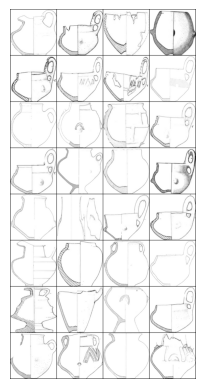

In [7]:
plot_grid(x)

### Define constants and hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PotteryVAE(
        latent_dim=128,
        input_size=(224, 224)
    ).to(device)

diagnostics = VAEDiagnostics(output_dir='vae_results')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training model

In [19]:
# Train for 100 epochs
for epoch in range(1, 51):
    train_loss, recon_loss, kld_loss = train_vae(
    model, my_dataset_dataloader, optimizer, device, epoch, diagnostics
    )
        
    # Final visualizations
    if epoch % 20 == 0:
        diagnostics.plot_latent_traversal(model)
        
        # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, f'pottery_vae_checkpoint_{epoch}.pt')


Epoch 1: Loss = 3980.1504 (Recon: 3962.8413, KLD: 69236.4793)
Epoch 2: Loss = 728.7010 (Recon: 724.5837, KLD: 16469.2447)
Epoch 3: Loss = 684.3116 (Recon: 681.8072, KLD: 10017.4888)
Epoch 4: Loss = 673.2188 (Recon: 671.6865, KLD: 6129.2908)
Epoch 5: Loss = 663.2401 (Recon: 662.2355, KLD: 4018.5338)
Epoch 6: Loss = 662.3531 (Recon: 661.2515, KLD: 4406.5515)
Epoch 7: Loss = 656.2680 (Recon: 655.3741, KLD: 3575.5750)
Epoch 8: Loss = 648.8760 (Recon: 648.1260, KLD: 3000.3865)
Epoch 9: Loss = 641.8106 (Recon: 641.1781, KLD: 2529.7797)
Epoch 10: Loss = 614.8528 (Recon: 614.4175, KLD: 1741.0780)
Epoch 11: Loss = 606.9013 (Recon: 606.4521, KLD: 1797.0831)
Epoch 12: Loss = 591.3758 (Recon: 591.0000, KLD: 1503.1020)
Epoch 13: Loss = 574.3712 (Recon: 574.0430, KLD: 1312.8182)
Epoch 14: Loss = 563.0318 (Recon: 562.7083, KLD: 1293.7816)
Epoch 15: Loss = 534.4720 (Recon: 534.1740, KLD: 1191.9260)
Epoch 16: Loss = 545.6551 (Recon: 545.2911, KLD: 1455.8244)
Epoch 17: Loss = 539.3062 (Recon: 538.9349, 

### Extract features

In [ ]:
latent_dims = []

for batch_idx, data in enumerate(my_dataset_dataloader_test):
    data = data.to(device)
    mu, log_var = model.encode(data)
    latent_dims.extend(mu.cpu().detach().numpy())

latent_dims_array = np.array(latent_dims)

### Dimensionality reduction and visualization

In [23]:
ump = umap.UMAP(n_neighbors=10, min_dist=0.05, metric='euclidean', n_components=2).fit_transform(latent_dims_array)
ump_k_nearest = umap.UMAP(n_neighbors=10, min_dist=0.05, metric='euclidean', n_components=2).fit_transform(latent_dims_array)

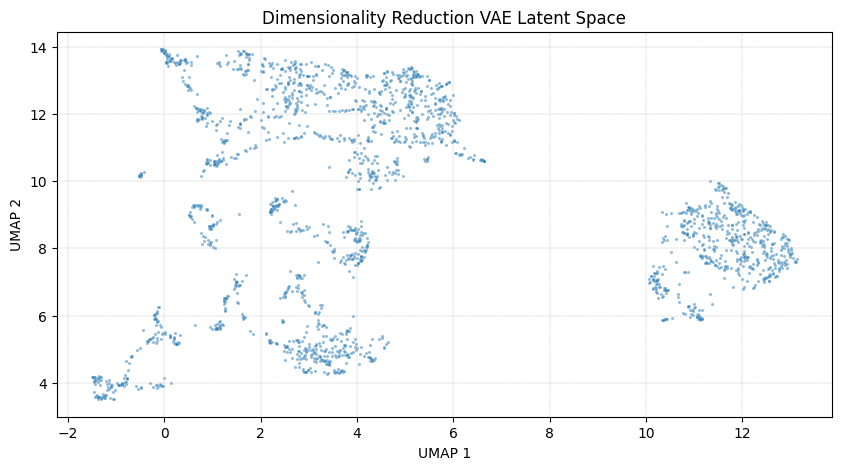

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df_plot, x='x', y='y', alpha=0.5, s = 5)

### set x axis name
plt.xlabel('UMAP 1')

### set y axis name
plt.ylabel('UMAP 2')

### set title

plt.title('Dimensionality Reduction VAE Latent Space')

### add a grid  

plt.grid(True, which='both', linestyle='--', lw = .3)

### save the plot

plt.savefig('UMAP_plot.png', dpi=300, bbox_inches='tight')

### K-nearest neighbors

In [ ]:
k = 5

kdt = KDTree(ump_k_nearest, leaf_size=30, metric='euclidean')
distances, indices = kdt.query(ump_k_nearest, k=k+1)


In [ ]:
### plot images of the nearest neighbors

def plot_nearest_neighbors(indices: np.ndarray, k: int, nrow: int = 4):
    n_images = indices.shape[0]
    fig, axes = plt.subplots(n_images, k+1, figsize=(2*(k+1), 2*n_images))
    
    for i, (neighbors, _) in enumerate(zip(indices, distances)):
        for j, idx in enumerate(neighbors):
            mask_path = my_dataset.mask_paths[idx]
            mask = Image.open(mask_path).convert('L')
            axes[i, j].imshow(mask, cmap='gray')
            axes[i, j].axis('off')
            
    plt.tight_layout()
    plt.savefig('nearest_neighbors.png', dpi=300, bbox_inches='tight')
    plt.show()    

In [78]:
np.random.choice(indices[:, 0], 5)

array([1138,  891, 1184,  489,  815], dtype=int64)

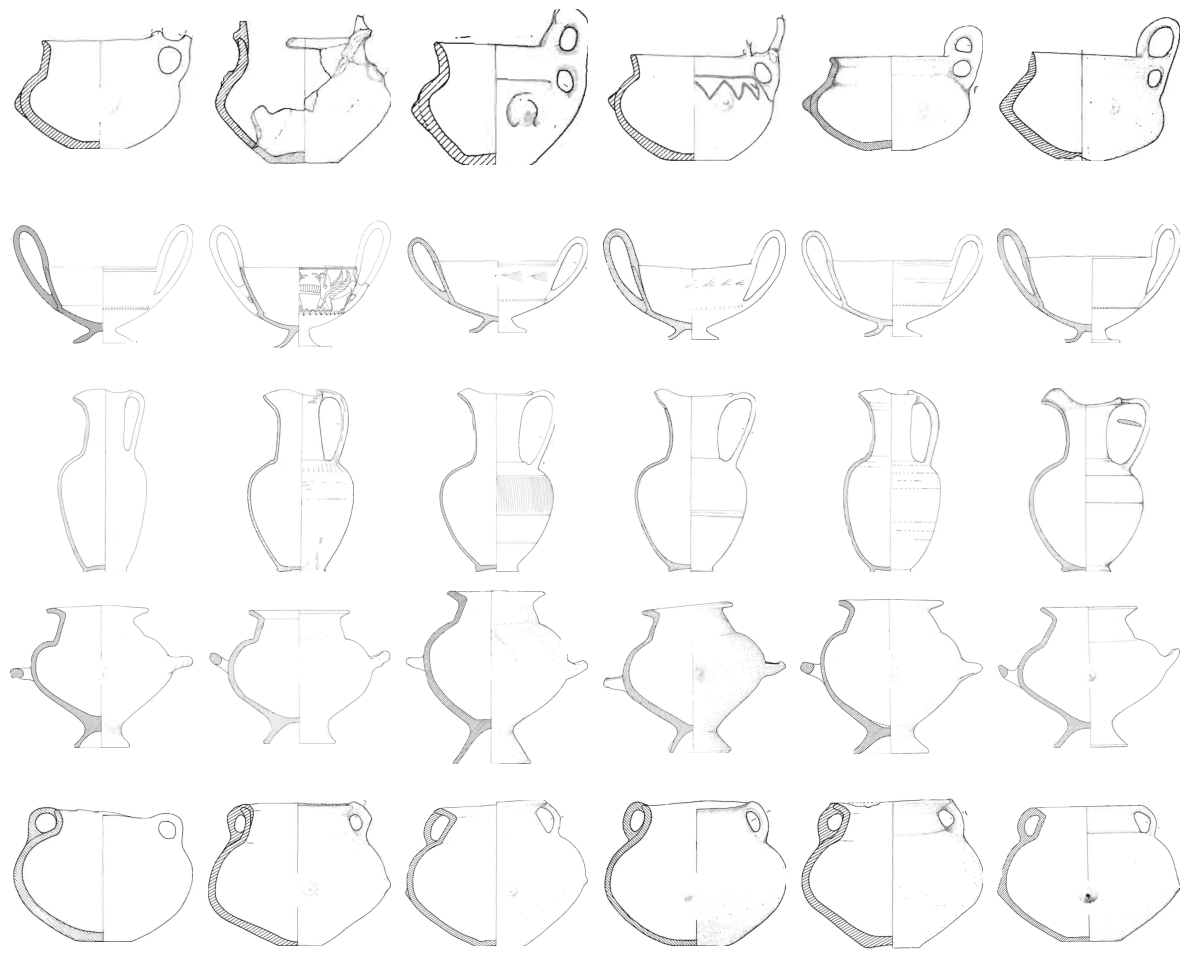

In [79]:
plot_nearest_neighbors(indices[np.random.choice(indices[:, 0], 5)], k)